In [1]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [2]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [3]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pickle
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, silhouette_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier

from tabpfn import TabPFNClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor

from imblearn.over_sampling import ADASYN, SMOTE

import warnings
warnings.filterwarnings('ignore')


### Data Pull

In [5]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

y_train_splitter = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/y_train_splitter.csv', index_col = 0)

# join greeks and add Epsilon
train_df.drop(['EJ'], axis = 1, inplace = True)
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Id'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)
train_df_nan = train_df[train_df['Epsilon'].isna()]
train_df = train_df[train_df['Epsilon'].notna()]
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])
train_df['Epsilon'] = train_df['Epsilon'].apply(lambda x: x.toordinal() - 734640)
train_df.reset_index(drop = True, inplace = True)
train_df = pd.concat([train_df, train_df_nan], axis = 0, ignore_index = True)
train_df.columns = train_df.columns.str.strip()

# Data Pre-Processing

In [6]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# create x and y train
X_train = train_df.drop(['Alpha', 'Beta', 'Delta', 'Gamma', 'Class'], axis = 1, inplace = False)
y_train_class = train_df['Class']

y_encoder = LabelEncoder()
y_train_alpha = y_encoder.fit_transform(train_df['Alpha'])
y_train_beta = y_encoder.fit_transform(train_df['Beta'])
y_train_delta = y_encoder.fit_transform(train_df['Delta'])
y_train_gamma = y_encoder.fit_transform(train_df['Gamma'])

In [7]:
# impute data
median_imputer = SimpleImputer(strategy = 'median')
imputed = median_imputer.fit_transform(X_train)
X_train = pd.DataFrame(imputed, columns = X_train.columns, index = X_train.index)

In [8]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

In [9]:
# features tiered by importance
tier_1_features = ['EP', 'CR', 'AY', 'AB', 'DU', 'DA', 'DI', 'DH', 'BC', 'DL', 'EE', 'BQ', 'BN']
tier_2_features = ['EG', 'DY', 'FD', 'AX', 'FR', 'FC', 'EL', 'DE', 'EU', 'FI', 'CS', 'EH', 'EB', 'CC', 'GL', 'FL', 'CU', 'AF']
tier_3_features = ['AH', 'AM', 'AR', 'AZ', 'BD', 'BP', 'BR', 'BZ', 'CB', 'CD', 'CF', 'CH', 'CL', 'CW', 'DF', 'DN', 'DV', 'FE', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI']
all_features = tier_1_features + tier_2_features + tier_3_features

# EDA

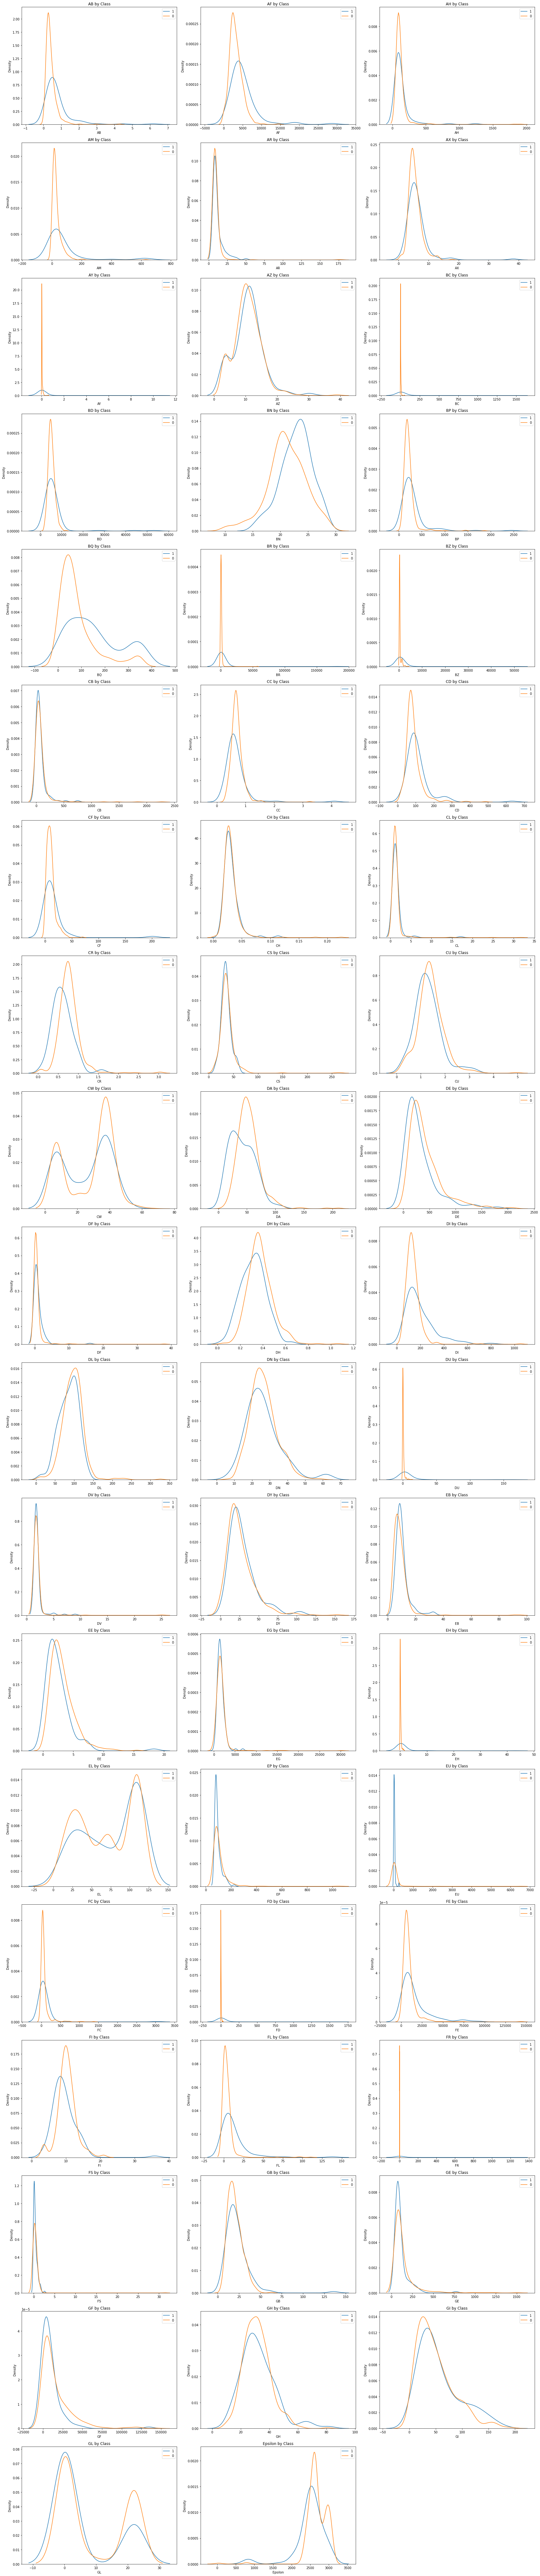

In [12]:
responses = [y_train_class]
features = X_train.columns
n_features = len(features)
n_cols = 3  # number of plots per row
n_rows = math.ceil(n_features / n_cols)  # rows needed per response

# Creating a figure for each response
for response in responses:
    df_1 = X_train[response == 1]
    df_0 = X_train[response == 0]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    axes = axes.ravel()  # flatten the axes array

    for j, feature in enumerate(features):
        ax = axes[j]  # select the current axis
        ax.set_title(f'{feature} by {response.name}')
        sns.kdeplot(df_1[feature], label = '1', ax = ax)
        sns.kdeplot(df_0[feature], label = '0', ax = ax)
        ax.legend()

    # remove the empty subplots
    for i in range(n_features, n_cols * n_rows):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## TSNE

In [13]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3'}
cluster_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9'}
error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C2', 'False Negative': 'C3'}

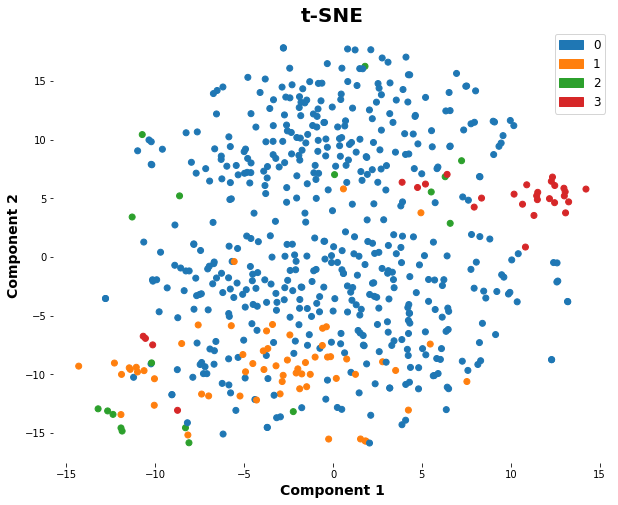

In [27]:
tsne_n = 2
tsne_df = X_train.drop(['Epsilon'], axis = 1, inplace = False)
tsne_scaled = StandardScaler().fit_transform(tsne_df)
tsne_transfromed = PowerTransformer().fit_transform(tsne_scaled)
tsne_df = pd.DataFrame(tsne_transfromed, columns = tsne_df.columns, index = tsne_df.index)
tsne = TSNE(n_components = tsne_n, perplexity = 50, random_state = random_seed) 
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
X_tsne = tsne.fit_transform(tsne_df)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = X_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class
tsne_df['Alpha'] = y_train_alpha

colors = tsne_df['Alpha'].map(alpha_color_map)

legend_elements = [Patch(color = clr, label = lbl) for lbl, clr in alpha_color_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 12)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()

### KMeans Clustering from TSNE

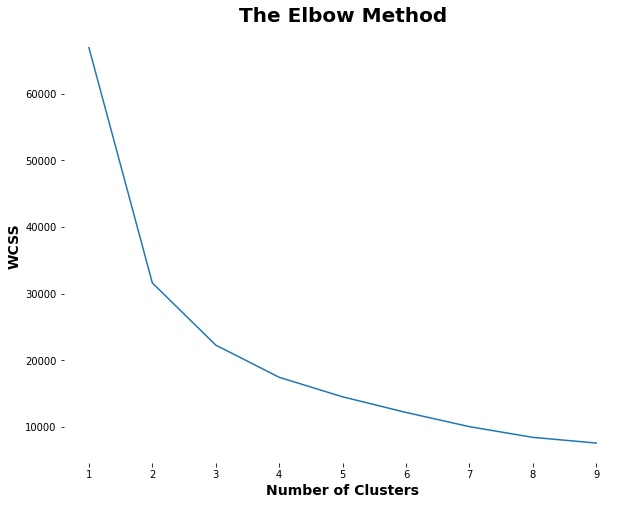

In [28]:
kmeans_df = tsne_df[tsne_columns]
range_clusters = range(1, 10)
wcss = []
for i in range_clusters:
    kmeans = KMeans(n_clusters = i, n_init = 'auto', random_state = random_seed)
    kmeans.fit(kmeans_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (10, 8))
plt.title('The Elbow Method', fontdict = font_dict_header)
plt.box(False)
plt.plot(range_clusters, wcss)
plt.xlabel('Number of Clusters', fontdict = font_dict_axistitle)
plt.ylabel('WCSS', fontdict = font_dict_axistitle)

plt.show()

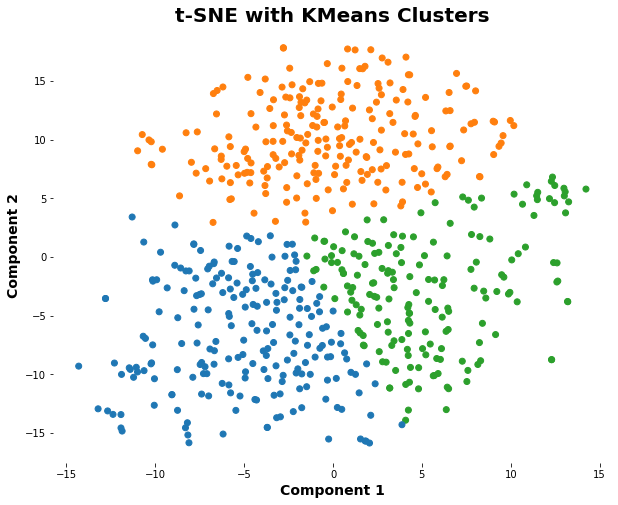

In [31]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state = random_seed)
kmeans.fit(kmeans_df)

labels = kmeans.labels_

tsne_df['Cluster'] = labels
y_train_tsne_cluster = tsne_df['Cluster']

colors = tsne_df['Cluster'].map(cluster_map)

# Plot components with cluster colors
plt.figure(figsize = (10, 8))
plt.title('t-SNE with KMeans Clusters', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', font_dict_axistitle)

plt.show()

# Prediction Model

In [32]:
class ICREnsemble(BaseEstimator):
    def __init__(self):
        xgboost = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        xgboost_norm = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        xtree = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5)
        tabpfn = TabPFNClassifier(N_ensemble_configurations = 64)
        guassian = GaussianProcessClassifier(kernel = 1.0 * RBF(1.0), optimizer = 'fmin_l_bfgs_b', n_restarts_optimizer = 0, max_iter_predict = 500)
                
        self.classifiers_ = [
            ('XGBoost', xgboost),
            ('XGBoost Norm', xgboost_norm),
            ('TabPFN', tabpfn)
        ]
        
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer()
        self.minmaxer = MinMaxScaler()
        self.normalizer = Normalizer()
        
        self.model_predictions = []
    
    def fit(self, X, y):
        clases, y = np.unique(y, return_inverse = True)
        self.classes_ = clases
        for model in self.classifiers_:
            if model[0] == 'TabPFN':
                model[1].fit(X, y, overwrite_warning = True)
                
            elif model[0] == 'Gaussian':
                X_scaled = self.scaler.fit_transform(X)
                X_transformed = self.transformer.fit_transform(X_scaled)
                X_normalized = self.normalizer.fit_transform(X_transformed)
                X_gaussian = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                
                model[1].fit(X_gaussian, y)
                
            elif model[0] == 'XGBoost Norm':
                X_scaled = self.scaler.fit_transform(X)
                X_transformed = self.transformer.fit_transform(X_scaled)
                X_minmaxed = self.minmaxer.fit_transform(X_transformed)
                X_normalized = self.normalizer.fit_transform(X_minmaxed)
                X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                
                model[1].fit(X_norm, y)
            
            else:
                model[1].fit(X, y)
            
    def predict_proba(self, X, weights = None):
        probabilities = []
        for model in self.classifiers_:
            if model[0] == 'Gaussian':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_normalized = self.normalizer.transform(X_transformed)
                X_gaussian = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_gaussian))
                
            if model[0] == 'XGBoost Norm':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_minmaxed = self.minmaxer.transform(X_transformed)
                X_normalized = self.normalizer.transform(X_minmaxed)
                X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_norm))
                
            else:
                probabilities.append(model[1].predict_proba(X))
                
        probabilities = np.stack(probabilities)
        self.model_predictions = probabilities
        
        if weights is None:
            weights = np.ones(len(self.classifiers_)) / len(self.classifiers_)

        assert len(weights) == probabilities.shape[0], 'weights should have same length as number of classifiers_'

        weighted_probabilities = np.average(probabilities, axis = 0, weights = weights)
            
        y_proba_0 = weighted_probabilities[:, 0 ].sum()
        y_proba_1 = weighted_probabilities[:, 1:].sum()
            
        new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
            
        return new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    
    def predict_proba_individual(self, X):
        probabilities = []
        probabilities_cols = []
        for model in self.classifiers_:
            if model[0] == 'Gaussian':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_normalized = self.normalizer.transform(X_transformed)
                X_gaussian = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_gaussian))
                
            if model[0] == 'XGBoost Norm':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_minmaxed = self.minmaxer.transform(X_transformed)
                X_normalized = self.normalizer.transform(X_minmaxed)
                X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_norm))
                
            else:
                probabilities.append(model[1].predict_proba(X))
            
            for class_ in model[1].classes_:
                probabilities_cols.append(model[0] + '_' + str(class_))
        
        return pd.DataFrame(np.concatenate(probabilities, axis = 1), columns = probabilities_cols, index = X.index)
    
    def to_pickel(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

In [ ]:
class TestModel(BaseEstimator):
    def __init__(self):
        xgboost = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        xgboost_norm = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        xtree = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5)
        tabpfn = TabPFNClassifier(N_ensemble_configurations = 64)
        guassian = GaussianProcessClassifier(kernel = 1.0 * RBF(1.0), optimizer = 'fmin_l_bfgs_b', n_restarts_optimizer = 0, max_iter_predict = 500)
                
        self.classifiers_ = [
            ('XGBoost', xgboost),
            ('XGBoost Norm', xgboost_norm),
            ('TabPFN', tabpfn)
        ]
        
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer()
        self.minmaxer = MinMaxScaler()
        self.normalizer = Normalizer()
        
        self.model_predictions = []
    
    def fit(self, X, y):
        clases, y = np.unique(y, return_inverse = True)
        self.classes_ = clases
        for model in self.classifiers_:
            if model[0] == 'TabPFN':
                model[1].fit(X, y, overwrite_warning = True)
                
            elif model[0] == 'Gaussian':
                X_scaled = self.scaler.fit_transform(X)
                X_transformed = self.transformer.fit_transform(X_scaled)
                X_normalized = self.normalizer.fit_transform(X_transformed)
                X_gaussian = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                
                model[1].fit(X_gaussian, y)
                
            elif model[0] == 'XGBoost Norm':
                X_scaled = self.scaler.fit_transform(X)
                X_transformed = self.transformer.fit_transform(X_scaled)
                X_minmaxed = self.minmaxer.fit_transform(X_transformed)
                X_normalized = self.normalizer.fit_transform(X_minmaxed)
                X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                
                model[1].fit(X_norm, y)
            
            else:
                model[1].fit(X, y)
            
    def predict_proba(self, X, weights = None):
        probabilities = []
        for model in self.classifiers_:
            if model[0] == 'Gaussian':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_normalized = self.normalizer.transform(X_transformed)
                X_gaussian = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_gaussian))
                
            if model[0] == 'XGBoost Norm':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_minmaxed = self.minmaxer.transform(X_transformed)
                X_normalized = self.normalizer.transform(X_minmaxed)
                X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_norm))
                
            else:
                probabilities.append(model[1].predict_proba(X))
                
        probabilities = np.stack(probabilities)
        self.model_predictions = probabilities
        
        if weights is None:
            weights = np.ones(len(self.classifiers_)) / len(self.classifiers_)

        assert len(weights) == probabilities.shape[0], 'weights should have same length as number of classifiers_'

        weighted_probabilities = np.average(probabilities, axis = 0, weights = weights)
            
        y_proba_0 = weighted_probabilities[:, 0 ].sum()
        y_proba_1 = weighted_probabilities[:, 1:].sum()
            
        new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
            
        return new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    
    def predict_proba_individual(self, X):
        probabilities = []
        probabilities_cols = []
        for model in self.classifiers_:
            if model[0] == 'Gaussian':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_normalized = self.normalizer.transform(X_transformed)
                X_gaussian = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_gaussian))
                
            if model[0] == 'XGBoost Norm':
                X_scaled = self.scaler.transform(X)
                X_transformed = self.transformer.transform(X_scaled)
                X_minmaxed = self.minmaxer.transform(X_transformed)
                X_normalized = self.normalizer.transform(X_minmaxed)
                X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
                probabilities.append(model[1].predict_proba(X_norm))
                
            else:
                probabilities.append(model[1].predict_proba(X))
            
            for class_ in model[1].classes_:
                probabilities_cols.append(model[0] + '_' + str(class_))
        
        return pd.DataFrame(np.concatenate(probabilities, axis = 1), columns = probabilities_cols, index = X.index)
    
    def to_pickel(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

### Model Evaluation

In [ ]:
def model_fit_predict(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    if model_name == 'TabPFN':
        model.fit(X, y, overwrite_warning = True)
    else:
        model.fit(X, y)
        
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index = X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    if len(predictions_df.columns) == 2:
        predictions_df = predictions_df[[model_name + '_1']]
    
    return predictions_df

In [ ]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

# Model Testing

In [ ]:
xgboost = XGBClassifier(booster = 'gbtree', tree_method = 'auto', n_estimators = 250, learning_rate = 0.07, max_depth = 9, subsample = 0.75, gamma = 0.05, random_state = random_seed)

In [43]:
X_scaled = StandardScaler().fit_transform(X_train)
X_transformed = PowerTransformer().fit_transform(X_scaled)
X_minmaxed = MinMaxScaler().fit_transform(X_transformed)
X_normalized = Normalizer().fit_transform(X_minmaxed)
X_norm = pd.DataFrame(X_normalized, columns = X_train.columns, index = X_train.index)

In [55]:
hgb = HistGradientBoostingClassifier(random_state=random_seed)

# Define the parameter grid
parameters = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_leaf': [10],
    'l2_regularization': [1],
    'max_iter': [100],
    'max_leaf_nodes': [15]
    
}

xgboost = XGBClassifier(booster = 'gbtree', tree_method = 'auto', n_estimators = 250, learning_rate = 0.07, max_depth = 9, subsample = 0.75, gamma = 0.05, random_state = random_seed)

# Create a GridSearchCV object
grid_obj = GridSearchCV(hgb, parameters, scoring = balanced_log_loss_scorer, cv = 5)

# Fit the GridSearchCV object to the data
grid_obj = grid_obj.fit(X_train, y_train_class)

# Get the best estimator
hgb = grid_obj.best_estimator_

# Fit the best estimator to the data
hgb.fit(X_train, y_train_class)

results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_regularization,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.224907,0.023007,0.00576,0.001389,1,0.1,3,100,15,10,"{'l2_regularization': 1, 'learning_rate': 0.1,...",-0.225791,-0.38951,-0.497502,-0.278756,-0.320954,-0.342503,0.094217,1


In [36]:
model = WeightedEnsemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [ ]:
y_train_splitter

In [ ]:
prediction_cols = X_train.columns
skf = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)
ensemble_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    # fit and predict
    predictions_df = model_fit_predict('Ensemble', model, fold, fold_y, oof, prediction_cols)

    # combine predictions
    ensemble_df = pd.concat([ensemble_df, predictions_df])

# add meta features
ensemble_df.sort_index(inplace = True)

In [ ]:
model_prediction_cols = ensemble_df.columns.to_list()
ensemble_df['Class'] = y_train_class

roc_auc = []
log_loss = []
    
def row_log_loss(row):
    if row['Class'] == 0:
        return -np.log(1 - row['Ensemble_1'])
    else:
        return -np.log(row['Ensemble_1'])
    
ensemble_df['Log Loss'] = ensemble_df.apply(row_log_loss, axis = 1)

def classify_error_types(row):
    if row['Class'] == 0 and row['Ensemble_1'] > 0.5:
        return 'False Positive'
    elif row['Class'] == 1 and row['Ensemble_1'] < 0.5:
        return 'False Negative'
    elif row['Class'] == 0 and row['Ensemble_1'] < 0.5:
        return 'True Negative'
    elif row['Class'] == 1 and row['Ensemble_1'] >= 0.5:
        return 'True Positive'
    
ensemble_df['Error Type'] = ensemble_df.apply(classify_error_types, axis = 1)
y_train_error_type = ensemble_df['Error Type']

for col in model_prediction_cols:
    print(col)
    print('ROC AUC:', roc_auc_score(ensemble_df['Class'], ensemble_df[col]))
    print('Log Loss:', competition_log_loss(ensemble_df['Class'], ensemble_df[col]))

ensemble_df.sort_values(by = 'Log Loss', ascending = False).head(25)

In [ ]:
model.model_predictions

In [ ]:
1000 // 14

In [ ]:
loss = 0.1536790084666712
model = WeightedEnsemble()
best_model = None
counter = 0
while loss > 0 and counter < 100:
    counter += 1
    
    X, X_val, y, y_val = train_test_split(X_train, y_train_class, test_size = 0.3, stratify = y_train_splitter)
    X, y = ADASYN().fit_resample(X, y)
    
    model.fit(X, y)
    y_pred = model.predict_proba(X_val)[:, 1]
    split_loss = competition_log_loss(y_val, y_pred)
        
    if split_loss < loss:
        loss = split_loss
        best_model = model
        best_model.to_pickel('best_model.pkl')
        print('New Best Loss: ', loss)
        counter = 0
        
    if counter == 500:
        print('No improvement in ', counter, ' iterations')
        print('Best Loss: ', loss)
    
    if counter % 10 == 0 and counter != 0:
        print('No improvement in ', counter, ' iterations')
    

### Important Featues

In [ ]:
best_model = pd.read_pickle('best_model.pkl')

In [ ]:
X_train['Sum'] = X_train.sum(axis = 1)

In [ ]:
X_train['Sum'].describe()

In [ ]:
best_model

In [ ]:
xgb = model.classifiers_[1][1]
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances (XGBoost)', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

### Visualize Errors

In [ ]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C2', 'False Negative': 'C3'}

In [ ]:
# TSNE
tsne_n = 2
tsne_df = X_train.drop(['Epsilon'], axis = 1, inplace = False)
tsne = TSNE(n_components = tsne_n, random_state = random_seed) 
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
x_tsne = tsne.fit_transform(tsne_df)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = x_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class
tsne_df['Error Type'] = y_train_error_type

error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C3', 'False Negative': 'C4'}
colors = tsne_df['Error Type'].map(error_type_map)

# map error types to sizes
size_map = {'True Positive': 30, 'True Negative': 30, 'False Positive': 200, 'False Negative': 200}
sizes = tsne_df['Error Type'].map(size_map)

legend_elements = [Patch(color=clr, label=lbl) for lbl, clr in error_type_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors, s = sizes)
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 12)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()


In [ ]:
# We will only use the components for clustering
X = tsne_df[tsne_columns]

# Range of clusters
range_clusters = range(1, 10)

# List to hold the WCSS for each number of clusters
wcss = []

for i in range_clusters:
    kmedoids = KMeans(n_clusters = i, n_init = 'auto', random_state = random_seed)
    kmedoids.fit(X)
    wcss.append(kmedoids.inertia_)

plt.figure(figsize = (10, 8))
plt.title('The Elbow Method', fontdict = font_dict_header)
plt.box(False)
plt.plot(range_clusters, wcss)
plt.xlabel('Number of Clusters', fontdict = font_dict_axistitle)
plt.ylabel('WCSS', fontdict = font_dict_axistitle)

plt.show()

In [ ]:
y_train_tsne_cluster = tsne_df['Cluster']

In [ ]:
# Define KMeans with 3 clusters
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state = random_seed)
kmeans.fit(X)

# get the labels of clusters
labels = kmeans.labels_

# Adding cluster labels to our tsne dataframe
tsne_df['Cluster'] = labels
y_train_tsne_cluster = tsne_df['Cluster']

# Create color map for clusters
cluster_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6'}
colors = tsne_df['Cluster'].map(cluster_map)

# Redefine size map to add the sizes for clusters
size_map = {'True Positive': 30, 'True Negative': 30, 'False Positive': 200, 'False Negative': 200}
sizes = tsne_df['Error Type'].map(size_map)

# Plot components with cluster colors
plt.figure(figsize = (10, 8))
plt.title('t-SNE with KMeans Clusters', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors, s = sizes)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', font_dict_axistitle)

plt.show()

In [ ]:
X_clusters = {}
y_clusters = {}

for i in range(n_clusters):
    X_clusters[i] = X_train[y_train_tsne_cluster == i]
    y_clusters[i] = y_train_class[y_train_tsne_cluster == i]


# Submission

In [ ]:
def prediction_pipeline(X, features):
    # pre-process
    X = X.copy()
    X.columns = X.columns.str.strip()
    X['Epsilon'] = X_train['Epsilon'].max() + 1
    X = X[features]
    imputed = median_imputer.transform(X)
    X = pd.DataFrame(imputed, columns = X.columns, index = X.index)
    
    # fit model and predict
    model.fit(X_train, y_train_class)
    X[['class_0', 'class_1']] = model.predict_proba(X)
    
    return X

In [ ]:
X_test = prediction_pipeline(test_df, prediction_cols)

In [ ]:
submission_df = pd.concat([test_df[['Id']], X_test[['class_0', 'class_1']]], axis = 1)
submission_df.to_csv('submission.csv', index = False)
submission_df